In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
df = pd.read_csv('data/clean_nonull.csv')

df = pd.concat([
    df.drop(columns=['VKORC1_SNP', 'CYP2C9 consensus']),
    pd.get_dummies(df['VKORC1_SNP'], prefix='VKORC1_SNP'),
    pd.get_dummies(df['CYP2C9 consensus'], prefix='CYP2C9')
], axis=1)

df['label'] = df['correct_dosage'].map({'low': 0, 'medium': 1, 'high': 2})

In [3]:
def clinical_baseline(x):
    x = np.squeeze(x)
    
    sqrt_weekly_dose = 4.0376 - 0.2546 * x[0] + 0.0118 * x[1] \
    + 0.0134 * x[2] - 0.6752 * x[3] \
    + 0.4060 * x[4] + 0.0443 * x[5] \
    + 1.2799 * x[6] - 0.5695 * x[7]
    
    
    cutoffs = np.array([0, np.sqrt(21), np.sqrt(49)])
    
    return np.where(cutoffs < sqrt_weekly_dose)[0].max()

In [125]:
np.random.seed(1)

S = 20


perfs = []
for s in tqdm(range(S)):
    order = np.random.choice(range(df.shape[0]), size=df.shape[0], replace=False)
    X = df.drop(columns=['correct_dosage', 'label']).iloc[order, :].values
    y = df['label'].values[order]
    
    #delta = 3 / X.shape[0] ## set it equal to |A|/T, for lack of a better option; see slides for UCB1 (lecture 10, slide 49)
    #R = 1  # arbitrarily
    #v = R * np.sqrt(9 * X.shape[1] * np.log(X.shape[0] / delta))
    v = np.sqrt(0.001)
    
    B = [np.eye(X.shape[1]) for _ in range(3)]
    F_h = [np.zeros(X.shape[1]) for _ in range(3)]
    mu_hat = [np.zeros(X.shape[1]) for _ in range(3)]

    chosen_arms = []
    for i in range(X.shape[0]):  # choose a patient        
        x_t = X[i] #/ np.linalg.norm(X[i])  # normalize vectors
        
        vals = []
        for a in range(3):
            mu_tilde = np.random.multivariate_normal(mu_hat[a], (v ** 2) * np.linalg.inv(B[a]))
            vals.append(mu_tilde.dot(x_t))
        
        pred_a = int(np.argmax(vals))
        
        r_t = 0 if y[i] == pred_a else -1
                
        # update the parameters
        B[pred_a] += np.outer(x_t, x_t)
        F_h[pred_a] += x_t * r_t
        mu_hat[pred_a] = np.linalg.inv(B[pred_a]).dot(F_h[pred_a])
        
        chosen_arms.append(pred_a)
        
    perf = pd.DataFrame({
        "run": s,
        "predicted_arm": chosen_arms,
        "true_arm": y,
        "clincal_baseline_predicted_arm": [clinical_baseline(x) for x in X]
    })

    perf['cumulative_accuracy'] = (
        perf['predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_fixed_baseline_accuracy'] = (
        perf['true_arm'] == 1
    ).cumsum() / (perf.index + 1)
    
    perf['cumulative_clinical_baseline_accuracy'] = (
        perf['clincal_baseline_predicted_arm'] == perf['true_arm']
    ).cumsum() / (perf.index + 1)

    perf['cumulative_regret'] = -1 * np.where(
        perf['predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perf['cumulative_fixed_baseline_regret'] = -1 * np.where(
        perf['true_arm'] == 1,
        0,
        -1
    ).cumsum()
    
    perf['cumulative_clinical_baseline_regret'] = -1 * np.where(
        perf['clincal_baseline_predicted_arm'] == perf['true_arm'],
        0,
        -1
    ).cumsum()
    
    perfs.append(perf)

ts_performances = pd.concat(perfs)
ts_performances['t'] = ts_performances.index

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.51s/it]


<AxesSubplot:xlabel='t'>

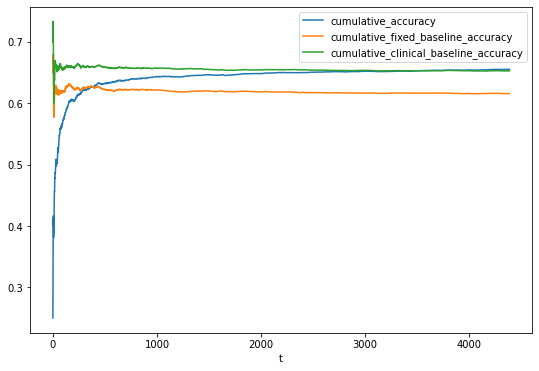

In [126]:
ts_grouped = ts_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].mean()    

ts_grouped[[
    'cumulative_accuracy',
    'cumulative_fixed_baseline_accuracy',
    'cumulative_clinical_baseline_accuracy'
]].plot(figsize=(9,6))

<AxesSubplot:xlabel='t'>

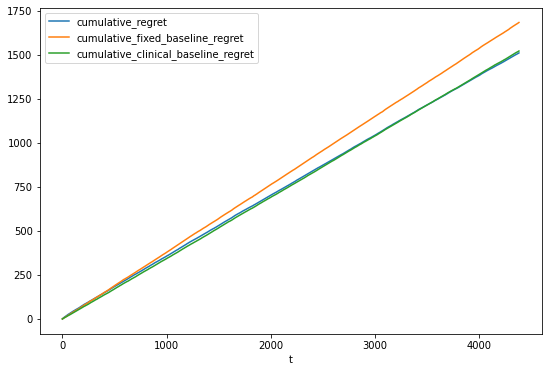

In [127]:
ts_grouped[[
    'cumulative_regret',
    'cumulative_fixed_baseline_regret',
    'cumulative_clinical_baseline_regret'
]].plot(figsize=(9,6))

In [128]:
ts_grouped

,cumulative_accuracy,cumulative_fixed_baseline_accuracy,cumulative_clinical_baseline_accuracy,cumulative_regret,cumulative_fixed_baseline_regret,cumulative_clinical_baseline_regret
t,,,,,,
0,0.250000,0.650000,0.700000,0.75,0.35,0.30
1,0.325000,0.650000,0.725000,1.35,0.70,0.55
2,0.400000,0.666667,0.733333,1.80,1.00,0.80
3,0.412500,0.675000,0.725000,2.35,1.30,1.10
4,0.400000,0.680000,0.700000,3.00,1.60,1.50
...,...,...,...,...,...,...
4381,0.655317,0.615917,0.652807,1510.40,1683.05,1521.40
4382,0.655305,0.615880,0.652783,1510.80,1683.60,1521.85
4383,0.655258,0.615842,0.652771,1511.35,1684.15,1522.25


In [129]:
ts_performances.groupby('t')[[
    'cumulative_accuracy', 'cumulative_fixed_baseline_accuracy', 'cumulative_clinical_baseline_accuracy',
    'cumulative_regret', 'cumulative_fixed_baseline_regret', 'cumulative_clinical_baseline_regret'
]].std()

,cumulative_accuracy,cumulative_fixed_baseline_accuracy,cumulative_clinical_baseline_accuracy,cumulative_regret,cumulative_fixed_baseline_regret,cumulative_clinical_baseline_regret
t,,,,,,
0,0.444262,0.489360,0.470162,0.444262,0.489360,0.470162
1,0.335410,0.328473,0.379577,0.670820,0.656947,0.759155
2,0.317151,0.286132,0.317151,0.951453,0.858395,0.951453
3,0.233326,0.257774,0.291322,0.933302,1.031095,1.165287
4,0.194666,0.209259,0.279096,0.973329,1.046297,1.395481
...,...,...,...,...,...,...
4381,0.016491,0.000228,0.000227,72.262242,0.998683,0.994723
4382,0.016544,0.000187,0.000185,72.511052,0.820783,0.812728
4383,0.016551,0.000170,0.000163,72.558706,0.745160,0.716350


In [116]:
#init
n_arms = 3
num_features = df.drop(columns=['correct_dosage', 'label']).shape[1]

v2_grid = np.linspace(0.0001, 0.005, 20)

accs = []
for v2 in tqdm(v2_grid):
    np.random.seed(1)

    B = [np.eye(num_features) for _ in range(n_arms)]
    F_h = [np.zeros(num_features) for _ in range(n_arms)]
    mu = [np.zeros(num_features) for _ in range(n_arms)]

    chosen_arms = []
    for i in range(X.shape[0]):
        #find best
        p = np.zeros(n_arms)
        b_vals = X[i] #/ np.linalg.norm(X[i])
        for a_ind in range(n_arms):
            cov = v2 * np.linalg.inv(B[a_ind])
            mu_tilde = np.random.multivariate_normal(mu[a_ind], cov)
            p[a_ind] = mu_tilde.dot(b_vals)
        a_choice = np.argmax(p)
        #actions = ['low' , 'medium' , 'high']
        #best_action = actions[a_choice]
        chosen_arms.append(a_choice)

        r = 0 if a_choice == y[i] else -1

        #update
        a_ind = a_choice #0*(a=='low') + 1*(a=='medium') + 2*(a=='high')
        #b_vals = np.array([x[feature] for feature in features])
        B[a_ind] = B[a_ind] + np.outer(b_vals,b_vals)
        F_h[a_ind] = F_h[a_ind] + r*b_vals
        mu[a_ind] = np.linalg.inv(B[a_ind]).dot(F_h[a_ind])

    accs.append((chosen_arms == y).mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.41s/it]


In [117]:
v2_grid[np.argmax(accs)]

0.0021631578947368417

In [118]:
accs[np.argmax(accs)]

0.6694026447788418

In [119]:
accs

[0.6632466940264478,
 0.6634746922024624,
 0.6671226630186958,
 0.668718650250798,
 0.6659826721386229,
 0.6678066575467396,
 0.6568627450980392,
 0.6598267213862289,
 0.6694026447788418,
 0.6680346557227542,
 0.6616507067943457,
 0.6666666666666666,
 0.6598267213862289,
 0.6609667122663019,
 0.6673506611947104,
 0.6609667122663019,
 0.6614227086183311,
 0.6650706794345645,
 0.6655266757865937,
 0.6639306885544916]

In [120]:
ts_grouped

,cumulative_accuracy,cumulative_fixed_baseline_accuracy,cumulative_clinical_baseline_accuracy,cumulative_regret,cumulative_fixed_baseline_regret,cumulative_clinical_baseline_regret
t,,,,,,
0,0.250000,0.650000,0.700000,0.75,0.35,0.30
1,0.325000,0.650000,0.725000,1.35,0.70,0.55
2,0.400000,0.666667,0.733333,1.80,1.00,0.80
3,0.412500,0.675000,0.725000,2.35,1.30,1.10
4,0.400000,0.680000,0.700000,3.00,1.60,1.50
...,...,...,...,...,...,...
4381,0.655317,0.615917,0.652807,1510.40,1683.05,1521.40
4382,0.655305,0.615880,0.652783,1510.80,1683.60,1521.85
4383,0.655258,0.615842,0.652771,1511.35,1684.15,1522.25
